In [1]:
import os
import ast
import textwrap
import tiktoken
import keyboard
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from typing import Optional

In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)

# Eliminar la primera p√°gina o portada del doc.

In [3]:
# Carga de documentos y extracci√≥n de informaci√≥n
# (aseg√∫rate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./docs/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (l√≠mita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [4]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

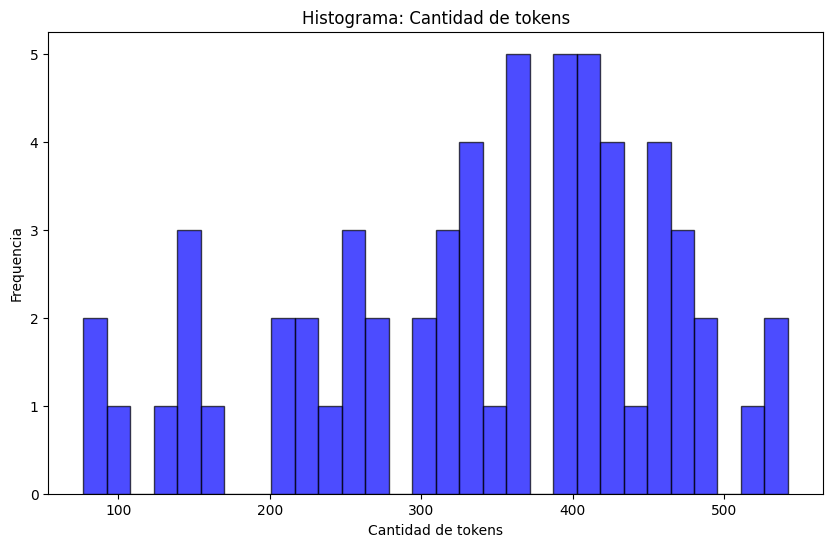

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.show()

In [6]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 20539


# 1. ¬øIncrustar de cero?
# 2. ¬øElegir un encrustamiento guardado?

In [7]:
user_input = input("Elige 1 o 2: ")

if user_input.lower() == "1":
    print('Elegiste 1')
    global_embeddings = [embeddings.embed_query(txt) for txt in texts]

    embed_name = input('¬øC√≥mo se llama esta incrustaci√≥n?: ') + '_emb' + '.txt'
    with open(rf'./embed/{embed_name}', 'w') as f:
        for i in global_embeddings:
            f.write("%s\n" % i)
    
elif user_input.lower() == "2":
    print('Elegiste 2')
    global_embeddings = []

    embed_name = input('Nombre del encrustamiento: ') + '_emb' + '.txt'

    with open(rf'./embed/{embed_name}', 'r') as f:
        for i in f:
            x = ast.literal_eval(i.strip())  # Convertir la cadena a lista de n√∫meros
            global_embeddings.append(x)

    global_embeddings = np.array(global_embeddings, dtype=float)
    
elif user_input != "1" and user_input != "2":
    print("No seleccionaste ning√∫n encrustamiento.")

Elegiste 1


In [8]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

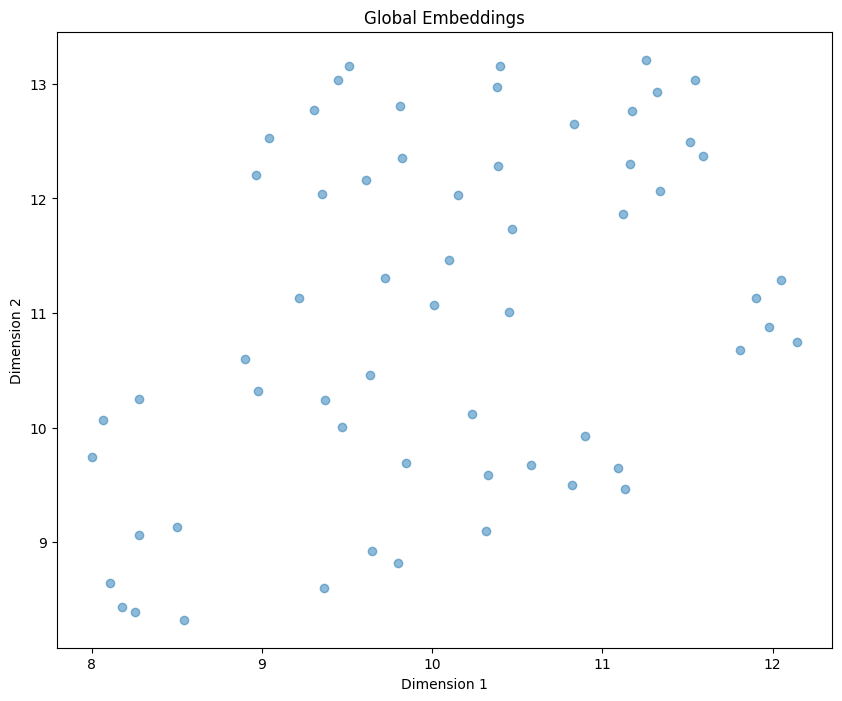

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


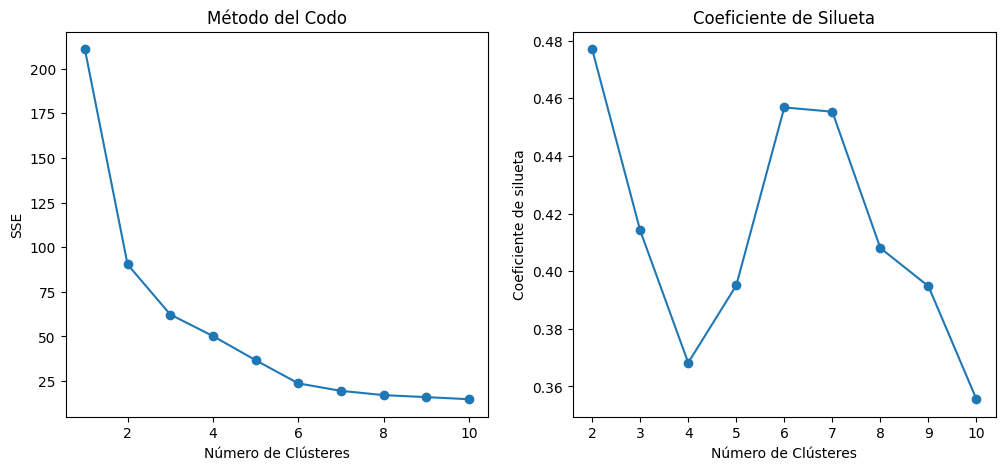

N√∫mero √≥ptimo de cl√∫steres seg√∫n el m√©todo del codo: 1
N√∫mero √≥ptimo de cl√∫steres seg√∫n el coeficiente de silueta: 2


In [10]:
# M√©todo del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no est√° definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el m√©todo del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('M√©todo del Codo')
plt.xlabel('N√∫mero de Cl√∫steres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('N√∫mero de Cl√∫steres')
plt.ylabel('Coeficiente de silueta')
plt.show()

# Determinaci√≥n del n√∫mero √≥ptimo de cl√∫steres
optimal_k_elbow = np.argmin(np.diff(sse)) + 1  # Codo
optimal_k_silhouette = k_values[1:][np.argmax(silhouette_scores)]  # Silueta

print(f"N√∫mero √≥ptimo de cl√∫steres seg√∫n el m√©todo del codo: {optimal_k_elbow}")
print(f"N√∫mero √≥ptimo de cl√∫steres seg√∫n el coeficiente de silueta: {optimal_k_silhouette}")

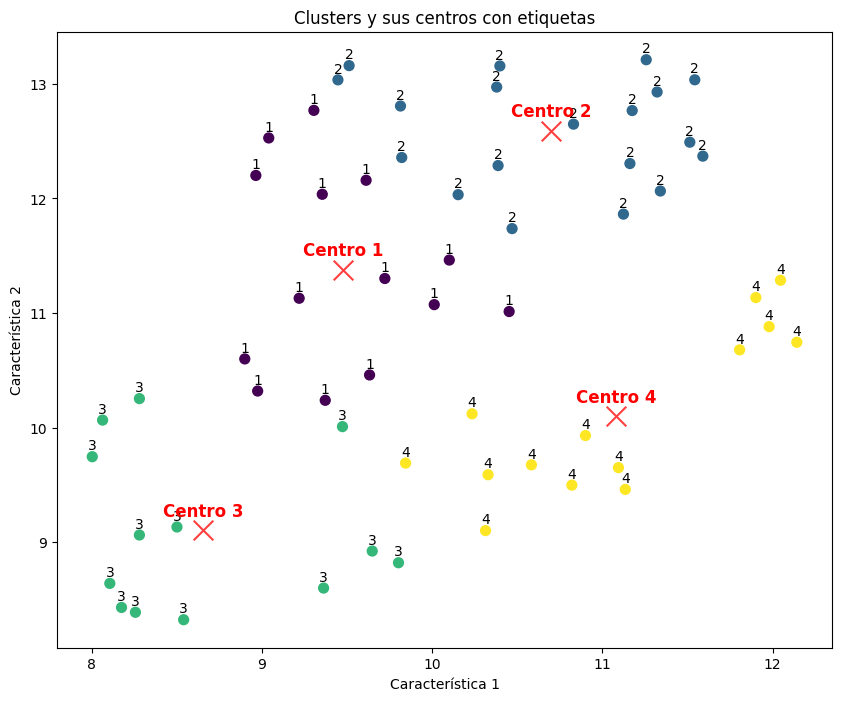

In [11]:
# Suponiendo que 'global_embeddings_reduced' ya est√° definido
optimal_k = input('¬øCu√°ntos cl√∫steres quiere usar?: ')

kmeans = KMeans(n_clusters=int(optimal_k), random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los cl√∫steres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los cl√∫steres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# A√±adir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# A√±adir etiquetas a los centros de los cl√∫steres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus centros con etiquetas")
plt.xlabel("Caracter√≠stica 1")
plt.ylabel("Caracter√≠stica 2")
plt.show()

# Aplicar an√°lisis a base de datos para determinar de qu√© habla (tema principal) cada cl√∫ster.

In [12]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()
doc_nom = input('Ingrese el nombre del documento')
df.to_csv(f'{doc_nom}.csv', sep=';', encoding='utf-8-sig')

In [13]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{4: 'Impacto de la innovaci√≥n de producto, innovaci√≥n de  proceso, innovaci√≥n organizacional y la percepci√≥n de la  corrupci√≥n, en la rentabilidad empresarial en Colombia   1       Impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n  organizacional y la percepci√≥n de la corrupci√≥n, en la rentabilidad empresarial en  Colombia       Gueiriluz Romero Chaparro   Juan Felipe G√≥ mez Quiceno       Universidad EAN   Facultad de Administraci√≥n   Maestr√≠a en administraci√≥n de empresas   Bogot√°  D.C, Colombia    Julio  de 2022 --- Impacto de la innovaci√≥n de producto, innovaci√≥n de  proceso, innovaci√≥n organizacional y la percepci√≥n de la  corrupci√≥n, en la rentabilidad empresarial en Colombia   2     Implicaciones de la innovaci√≥n empresarial  en Colombia   Juan Felipe G√≥mez Quiceno   Gueiriluz Romero Chaparro     Trabajo de grado presentado como  requisito para optar al t√≠tulo de:   Magister en administraci√≥n de empresas   Director :  Juan Manuel Gil 

In [14]:
template = """Eres un revisor bibliogr√°fico profesional encargado de crear res√∫menes extremadamente detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [15]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{4: 'El texto "Impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de la corrupci√≥n, en la rentabilidad empresarial en Colombia" realizado por Gueiriluz Romero Chaparro y Juan Felipe G√≥mez Quiceno, presenta un an√°lisis detallado sobre c√≥mo la innovaci√≥n en diferentes aspectos y la percepci√≥n de la corrupci√≥n afectan la rentabilidad de las empresas en Colombia.\n\nEl trabajo de grado se enfoca en identificar el impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de corrupci√≥n en la rentabilidad empresarial en Colombia. Se plantean objetivos espec√≠ficos como analizar el impacto de la innovaci√≥n de producto, evaluar el impacto de la innovaci√≥n de proceso, dar cuenta del impacto de la innovaci√≥n organizacional y comprender la percepci√≥n de corrupci√≥n en la innovaci√≥n empresarial en Colombia.\n\nSe utiliza un enfoque de investigaci√≥n cuantitativa para abordar la preg

In [16]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{4: ['El texto "Impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de la corrupci√≥n, en la rentabilidad empresarial en Colombia" realizado por Gueiriluz Romero Chaparro y Juan Felipe G√≥mez Quiceno, presenta un an√°lisis detallado sobre c√≥mo la innovaci√≥n en diferentes aspectos y la percepci√≥n de la corrupci√≥n afectan la rentabilidad de las empresas en Colombia.\n\nEl trabajo de grado se enfoca en identificar el impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de corrupci√≥n en la rentabilidad empresarial en Colombia. Se plantean objetivos espec√≠ficos como analizar el impacto de la innovaci√≥n de producto, evaluar el impacto de la innovaci√≥n de proceso, dar cuenta del impacto de la innovaci√≥n organizacional y comprender la percepci√≥n de corrupci√≥n en la innovaci√≥n empresarial en Colombia.\n\nSe utiliza un enfoque de investigaci√≥n cuantitativa para abordar la pre

In [17]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{4: 'El texto "Impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de la corrupci√≥n, en la rentabilidad empresarial en Colombia" realizado por Gueiriluz Romero Chaparro y Juan Felipe G√≥mez Quiceno, se centra en analizar c√≥mo la innovaci√≥n en diferentes aspectos y la percepci√≥n de la corrupci√≥n influyen en la rentabilidad de las empresas en Colombia.\n\nEl estudio se enfoca en identificar el impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de corrupci√≥n en la rentabilidad empresarial en Colombia. Se plantean objetivos espec√≠ficos como analizar el impacto de la innovaci√≥n de producto, evaluar el impacto de la innovaci√≥n de proceso, dar cuenta del impacto de la innovaci√≥n organizacional y comprender la percepci√≥n de corrupci√≥n en la innovaci√≥n empresarial en Colombia.\n\nSe utiliza un enfoque de investigaci√≥n cuantitativa y se presenta un modelo de variables junt

In [18]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [19]:
combined_texts[:10]

['Impacto de la innovaci√≥n de producto, innovaci√≥n de  proceso, innovaci√≥n organizacional y la percepci√≥n de la  corrupci√≥n, en la rentabilidad empresarial en Colombia   1       Impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n  organizacional y la percepci√≥n de la corrupci√≥n, en la rentabilidad empresarial en  Colombia       Gueiriluz Romero Chaparro   Juan Felipe G√≥ mez Quiceno       Universidad EAN   Facultad de Administraci√≥n   Maestr√≠a en administraci√≥n de empresas   Bogot√°  D.C, Colombia    Julio  de 2022',
 'Impacto de la innovaci√≥n de producto, innovaci√≥n de  proceso, innovaci√≥n organizacional y la percepci√≥n de la  corrupci√≥n, en la rentabilidad empresarial en Colombia   2     Implicaciones de la innovaci√≥n empresarial  en Colombia   Juan Felipe G√≥mez Quiceno   Gueiriluz Romero Chaparro     Trabajo de grado presentado como  requisito para optar al t√≠tulo de:   Magister en administraci√≥n de empresas   Director :  Juan Manuel Gil Bar

In [20]:
# Nombre del archivo de texto
file_name = "final_test.txt"

# Escribir la lista en el archivo de texto
with open(file_name, 'w', encoding='utf-8') as f:
    for t in combined_texts:
        f.write("%s\n" % t)

# Leer el contenido del archivo y mostrarlo
with open(file_name, 'r', encoding='utf-8') as f:
    content = f.read()

textos = text_splitter.split_text(content)

# Guardar los kb en una carpeta (kbs)

### 1. Ense√±ar

In [21]:
persist_directory = input('¬øC√≥mo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=textos,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Ense√±ar=Done) y pregunta de control

In [22]:
persist_directory = input('¬øQu√© knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¬øCu√°l es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

18


In [23]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisi√≥n biliogr√°fica que habla Espa√±ol.

Tu tarea consiste en:

1. Leer detalladamente la informaci√≥n proporcionada en documentos que generalmente son
art√≠culos cient√≠ficos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas espec√≠ficas. Evita concluir tus respuestas con un 
p√°rrafo que comience con 'En resumen,...'. Var√≠a las conclusiones de tus respuestas para que 
sean m√°s diversas y creativas.

3. Ser carism√°tico y ofrecer informaci√≥n sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No s√©'.

NUNCA hables espec√≠ficamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusi√≥n predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [24]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"][:5]:
        print(contexto)

In [25]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¬øCu√°l es el nombre del art√≠culo?
El nombre del art√≠culo es "Impacto de la innovaci√≥n de producto,
innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de la
corrupci√≥n, en la rentabilidad empresarial en Colombia" realizado por
Gueiriluz Romero Chaparro y Juan Felipe G√≥mez Quiceno.

Referencias:
page_content='Adem√°s de esto, esta investigaci√≥n  tiene aplicaciones para las peque√±as y medianas empresas en Colombia de todos los  sector es econ√≥micos.   Y por √∫ltimo, desde el punto de vista acad√©mico, esta investigaci√≥n permiti√≥ realizar una  integraci√≥n de la literatura que aborda la problem√°tica de los impactos de la innovaci√≥n  empresarial, sin embargo poco se menciona sobre los impactos de ella en espec√≠ficamente  la rentabilidad, y de esta manera se contribuye a llenar el vac√≠o te√≥rico que nos  encontramos en esta tem√°tica concreta.'
page_content='El texto "Impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y l

In [28]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¬øCu√°les son los puntos clave del art√≠culo?
Los puntos clave del art√≠culo se centran en analizar el impacto de la
innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n
organizacional y la percepci√≥n de la corrupci√≥n en la rentabilidad
empresarial en Colombia. Se plantea un enfoque de investigaci√≥n
cuantitativa, utilizando un modelo de variables y procedimientos
metodol√≥gicos espec√≠ficos. Se destaca la importancia de la innovaci√≥n
en el contexto empresarial, as√≠ como la necesidad de comprender c√≥mo
estos factores influyen en la rentabilidad de las empresas. Adem√°s, se
menciona la relevancia de la integraci√≥n de la literatura existente en
la problem√°tica de los impactos de la innovaci√≥n empresarial,
contribuyendo a llenar un vac√≠o te√≥rico en este tema espec√≠fico. Se
analizan variables como la introducci√≥n de productos o servicios
nuevos, procesos nuevos o mejorados, as√≠ como la percepci√≥n de la
corrupci√≥n como obst√°culo para la rentabilidad.

Referencias:
pa

In [29]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¬øQu√© percepci√≥n se tiene de la corrupci√≥n en el art√≠culo?
Seg√∫n el art√≠culo, se menciona que la percepci√≥n de corrupci√≥n en
Colombia es bastante relevante, ya que se hace referencia a que los
pol√≠ticos y funcionarios del Estado est√°n permeados por la corrupci√≥n.
Adem√°s, se destaca que Colombia ocup√≥ el puesto 92 entre 180 pa√≠ses en
el √çndice de percepci√≥n de la corrupci√≥n de 2020, lo que indica que la
corrupci√≥n es un problema significativo en el pa√≠s. Por otro lado, se
menciona que la corrupci√≥n puede afectar negativamente la rentabilidad
empresarial, lo que sugiere que es un tema importante a considerar en
el contexto del estudio.

Referencias:
page_content='El texto "Impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de la corrupci√≥n, en la rentabilidad empresarial en Colombia" realizado por Gueiriluz Romero Chaparro y Juan Felipe G√≥mez Quiceno, se centra en analizar c√≥mo la innovaci√≥n en diferentes asp

# Hacer historial

In [ ]:
# Para archivos grandes debes dividir el texto

# # Diccionario inicial
# data = {
#     2: 'El impacto de la innovaci√≥n de producto, innovaci√≥n de proceso, innovaci√≥n organizacional y la percepci√≥n de la corrupci√≥n en la rentabilidad empresarial en Colombia es un tema abordado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe G√≥mez Quiceno de la Universidad EAN. El prop√≥sito de la investigaci√≥n es analizar'
# }

# # Obtener el texto original
# original_text = data[2]

# # Encontrar el punto medio
# mid_point = len(original_text) // 2

# # Definir el tama√±o del solapamiento
# overlap_size = 50

# # Calcular los puntos de divisi√≥n con solapamiento
# start_overlap = max(mid_point - overlap_size // 2, 0)
# end_overlap = min(mid_point + overlap_size // 2, len(original_text))

# # Dividir el texto en dos partes con solapamiento
# first_half = original_text[:end_overlap]
# second_half = original_text[start_overlap:]

# # Crear nuevas llaves en el diccionario
# data[2] = first_half
# data[3] = second_half

# # Imprimir el diccionario actualizado
# print(data)